In [1]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U kaleido

Requirement already up-to-date: kaleido in ./.local/lib/python3.8/site-packages (0.2.1)
Note: you may need to restart the kernel to use updated packages.


### Učitavanje biblioteka

In [4]:
# Biblioteke za pripremu i vizualizaciju podataka
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "png"
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder

# pip install scikit-surprise
# Biblioteke za kreiranje modela i evaluaciju
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy

In [5]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Biblioteke za rad sa modelima zasnovanim na dubokom učenju
from keras.layers import Embedding, Input, Flatten, dot, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#from tensorflow.keras.utils import model_to_dot

2023-07-02 15:25:05.074268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 15:25:05.497145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-02 15:25:05.497192: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-02 15:25:06.772189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Učitavanje skupa podataka

In [8]:
# Učitavanje skupa podataka 
def loaddata(filename):
    df = pd.read_csv(f'{filename}.csv',sep=',',error_bad_lines=False, warn_bad_lines=False, encoding='latin-1')
    return df

data = loaddata('skup_amazon/fashion')

/tmp/ipykernel_7433/3257419211.py:3: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



/tmp/ipykernel_7433/3257419211.py:3: FutureWarning:

The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.





### Pretprocesiranje

In [9]:
ratings = data.drop(['verified', 'reviewTime', 'unixReviewTime', 'reviewerName', 'reviewText', 'summary', 'vote', 'style/Color:', 'style/Size:', 'image/0', 'style/Metal Type:', 'image/1', 'image/2', 'image/3', 'image/4', 'image/5', 'image/6', 'image/7', 'image/8', 'image/9', 'image/10', 'image/11', 'image/12', 'image/13', 'style/Size Name:', 'style/Style:'], axis=1)
ratings = ratings[['reviewerID','asin','overall']]
ratings.head(3)

,reviewerID,asin,overall
0,A1D4G1SNUZWQOT,7106116521,5
1,A3DDWDH9PX2YX2,7106116521,2
2,A2MWC41EW7XL15,7106116521,4


In [10]:
def encode_user_item(df, user_col, item_col, rating_col):
    """Funkcija za enkoiranje korisnika i stavki
    
    Parametri:     
        df (pd.DataFrame): Pandas dataframe - tabela sa interakcijama.
        user_col (string): Naziv kolone koja predstavlja korisnika.
        item_col (string): Naziv kolone koja predstavlja stavku.
        rating_col (string): Naziv kolone koja predstavlja ocenu.
    
    Povratna vrednost: 
        encoded_df (pd.DataFrame): Modifikovan dataframe sa indeksima korisnika i stavki
    """
    
    encoded_df = df.copy()
    
    user_encoder = LabelEncoder() # Enkodiranje vrednosti promenljie sa vrednostima između 0 i n_classes-1.
    user_encoder.fit(encoded_df[user_col].values)
    n_users = len(user_encoder.classes_)
    
    item_encoder = LabelEncoder()
    item_encoder.fit(encoded_df[item_col].values)
    n_items = len(item_encoder.classes_)

    encoded_df["USER"] = user_encoder.transform(encoded_df[user_col])
    encoded_df["ITEM"] = item_encoder.transform(encoded_df[item_col])
    
    encoded_df.rename({rating_col: "RATING"}, axis=1, inplace=True)
    
    print("Broj korisnika: ", n_users)
    print("Broj stavki: ", n_items)
    
    return encoded_df, user_encoder, item_encoder

In [11]:
DATA, user_encoder, item_encoder = encode_user_item(ratings, "reviewerID", "asin", "overall")

Broj korisnika:  18320
Broj stavki:  141


In [12]:
DATA

,reviewerID,asin,RATING,USER,ITEM
0,A1D4G1SNUZWQOT,7106116521,5,1842,0
1,A3DDWDH9PX2YX2,7106116521,2,11460,0
2,A2MWC41EW7XL15,7106116521,4,7912,0
3,A2UH2QQ275NV45,7106116521,2,8958,0
4,A89F3LQADZBS5,7106116521,3,14563,0
...,...,...,...,...,...
19994,A2I8U2L6ZOLPP9,B000P0X15G,5,7307,140
19995,A38SLX4EMMLSTL,B000P0X15G,5,10827,140
19996,A24NGH58L8CWDT,B000P0X15G,5,5509,140
19997,A1NJ9OSQZOZB02,B000P0X15G,5,3183,140


In [13]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(18320, 141)

In [14]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [15]:
# Mešanje skupa podataka

shuffled_ratings = DATA.sample(frac = 1, random_state = 1).reset_index() # shuffle dataset
shuffled_ratings = shuffled_ratings.drop(['index'], axis = 1)
shuffled_ratings.head(3)

,reviewerID,asin,RATING,USER,ITEM
0,AEQ0PWKRT7ANQ,B000KPIHQ4,5,15422,115
1,A2I0M3X174ADSW,B000HR77R0,2,7274,100
2,AD8Y84L4457LI,B000NBIMG0,5,15223,128


In [16]:
shuffled_ratings.columns

Index(['reviewerID', 'asin', 'RATING', 'USER', 'ITEM'], dtype='object')

### Podela skupa podataka

In [17]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

In [18]:
X = shuffled_ratings.drop(['reviewerID', 'asin', 'RATING'], axis=1)
Y = shuffled_ratings['RATING']

In [19]:
threshold = int(len(Y)*0.7)

X_train = X[:threshold] # 70% podataka pripada skupu za trening (X)
X_test = X[threshold:] # 30% podataka pripada skupu za testiranje (X)

Y_train = Y[:threshold] # 70% podataka pripada skupu za trening (Y)
Y_test = Y[threshold:] # 30% podataka pripada skupu za testiranje (Y)

In [20]:
X_train.shape, X_test.shape

((13999, 2), (6000, 2))

In [21]:
Y_train.shape, Y_test.shape

((13999,), (6000,))

In [22]:
Y_train.value_counts()

5    8847
4    2526
3    1174
1     777
2     675
Name: RATING, dtype: int64

In [23]:
Y_test.value_counts()

5    3856
4    1076
3     469
1     301
2     298
Name: RATING, dtype: int64

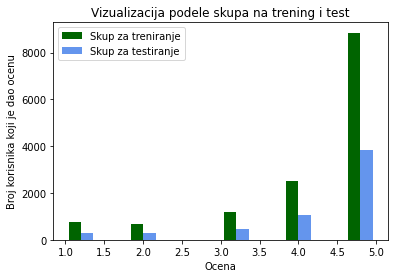

In [24]:
plt.title("Vizualizacija podele skupa na trening i test")
plt.xlabel('Ocena')
plt.ylabel('Broj korisnika koji je dao ocenu')
plt.hist([Y_train, Y_test], color=['darkgreen', 'cornflowerblue'], label=['Skup za treniranje', 'Skup za testiranje'])
plt.legend(loc='best')
plt.show()

In [25]:
Y_train.shape

(13999,)

### Kreiranje modela

In [26]:
# Broj latentnih faktora
n_latent_factors = 50

# broj jedinstvenih korisnika i proizvoda
n_users, n_products = len(shuffled_ratings['USER'].unique()), len(shuffled_ratings['ITEM'].unique())

In [27]:
# Arhitektura modela

# Slojevi za korisnika
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Slojevi za proizvod
product_input = Input(shape=(1,), name='Product_Input')
product_embeddings = Embedding(input_dim = n_products, output_dim=n_latent_factors, input_length=1, name='Product_Embedding') (product_input)
product_vector = Flatten(name='Product_Vector') (product_embeddings)


# Skalarni proizvod
merged_vectors = dot([user_vector, product_vector], name='Dot_Product', axes=1)
model = Model([user_input, product_input], merged_vectors)

2023-07-02 15:25:09.338712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-02 15:25:09.338772: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-02 15:25:09.338803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jovana-kubuntu): /proc/driver/nvidia/version does not exist
2023-07-02 15:25:09.339603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
#SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Product_Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        916000      ['User_Input[0][0]']             
                                                                                                  
 Product_Embedding (Embedding)  (None, 1, 50)        7050        ['Product_Input[0][0]']          
                                                                                              

In [30]:
optimizer = Adam(learning_rate = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer)

### Treniranje i testiranje modela za različite vrednosti parametara batch_size i epochs i evaluacija

In [31]:
batch_size = 128
epochs = 20

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/20
110/110 - 3s - loss: 19.6884 - val_loss: 19.8858 - 3s/epoch - 23ms/step
Epoch 2/20
110/110 - 2s - loss: 19.6270 - val_loss: 19.8743 - 2s/epoch - 16ms/step
Epoch 3/20
110/110 - 2s - loss: 19.4287 - val_loss: 19.8354 - 2s/epoch - 16ms/step
Epoch 4/20
110/110 - 2s - loss: 18.9197 - val_loss: 19.7492 - 2s/epoch - 16ms/step
Epoch 5/20
110/110 - 2s - loss: 17.9782 - val_loss: 19.6099 - 2s/epoch - 16ms/step
Epoch 6/20
110/110 - 2s - loss: 16.5955 - val_loss: 19.4200 - 2s/epoch - 16ms/step
Epoch 7/20
110/110 - 2s - loss: 14.8551 - val_loss: 19.1910 - 2s/epoch - 17ms/step
Epoch 8/20
110/110 - 2s - loss: 12.8891 - val_loss: 18.9473 - 2s/epoch - 16ms/step
Epoch 9/20
110/110 - 2s - loss: 10.8422 - val_loss: 18.7036 - 2s/epoch - 16ms/step
Epoch 10/20
110/110 - 2s - loss: 8.8524 - val_loss: 18.4784 - 2s/epoch - 16ms/step
Epoch 11/20
110/110 - 2s - loss: 7.0261 - val_loss: 18.2779 - 2s/epoch - 16ms/step
Epoch 12/20
110/110 - 2s - loss: 5.4355 - val_loss: 18.1113 - 2s/epoch - 16ms/step
Epoc

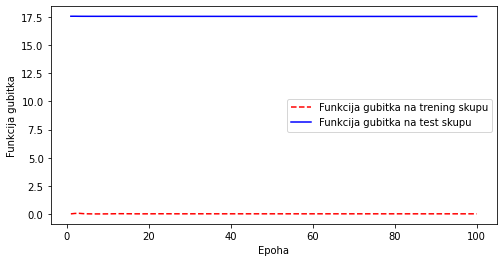

(0.014023113995790482, 17.551349639892578)

In [67]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[19], test_loss[19]

In [35]:
score = model.evaluate([X_test['USER'], X_test['ITEM']], Y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

188/188 [==============================] - 0s 1ms/step - loss: 17.6371

RMSE: 4.1997


In [36]:
y_pred = model.evaluate([X_test['USER'], X_test['ITEM']], Y_test)

188/188 [==============================] - 0s 2ms/step - loss: 17.6371


In [37]:
batch_size = 128
epochs = 10

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/10
110/110 - 2s - loss: 0.4055 - val_loss: 17.6255 - 2s/epoch - 16ms/step
Epoch 2/10
110/110 - 2s - loss: 0.3188 - val_loss: 17.6174 - 2s/epoch - 19ms/step
Epoch 3/10
110/110 - 2s - loss: 0.2537 - val_loss: 17.6111 - 2s/epoch - 17ms/step
Epoch 4/10
110/110 - 2s - loss: 0.2045 - val_loss: 17.6064 - 2s/epoch - 17ms/step
Epoch 5/10
110/110 - 2s - loss: 0.1664 - val_loss: 17.6026 - 2s/epoch - 17ms/step
Epoch 6/10
110/110 - 2s - loss: 0.1364 - val_loss: 17.6000 - 2s/epoch - 15ms/step
Epoch 7/10
110/110 - 2s - loss: 0.1124 - val_loss: 17.5979 - 2s/epoch - 16ms/step
Epoch 8/10
110/110 - 2s - loss: 0.0934 - val_loss: 17.5966 - 2s/epoch - 15ms/step
Epoch 9/10
110/110 - 2s - loss: 0.0777 - val_loss: 17.5955 - 2s/epoch - 15ms/step
Epoch 10/10
110/110 - 2s - loss: 0.0649 - val_loss: 17.5948 - 2s/epoch - 15ms/step


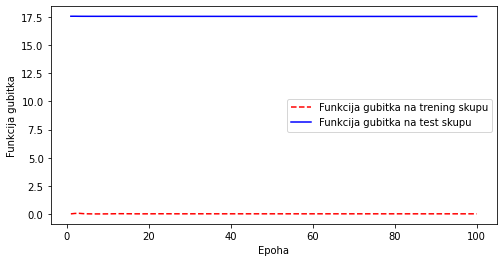

(0.010085029527544975, 17.553762435913086)

In [68]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[9], test_loss[9]

In [40]:
batch_size = 64
epochs = 20

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/20
219/219 - 4s - loss: 0.0533 - val_loss: 17.5938 - 4s/epoch - 18ms/step
Epoch 2/20
219/219 - 4s - loss: 0.0407 - val_loss: 17.5937 - 4s/epoch - 17ms/step
Epoch 3/20
219/219 - 4s - loss: 0.0321 - val_loss: 17.5933 - 4s/epoch - 17ms/step
Epoch 4/20
219/219 - 4s - loss: 0.0237 - val_loss: 17.5931 - 4s/epoch - 16ms/step
Epoch 5/20
219/219 - 4s - loss: 0.0190 - val_loss: 17.5932 - 4s/epoch - 18ms/step
Epoch 6/20
219/219 - 4s - loss: 0.0158 - val_loss: 17.5929 - 4s/epoch - 17ms/step
Epoch 7/20
219/219 - 3s - loss: 0.0125 - val_loss: 17.5937 - 3s/epoch - 15ms/step
Epoch 8/20
219/219 - 3s - loss: 0.0106 - val_loss: 17.5915 - 3s/epoch - 15ms/step
Epoch 9/20
219/219 - 3s - loss: 0.0102 - val_loss: 17.5939 - 3s/epoch - 15ms/step
Epoch 10/20
219/219 - 3s - loss: 0.0101 - val_loss: 17.5920 - 3s/epoch - 15ms/step
Epoch 11/20
219/219 - 3s - loss: 0.0099 - val_loss: 17.5926 - 3s/epoch - 15ms/step
Epoch 12/20
219/219 - 3s - loss: 0.0114 - val_loss: 17.5933 - 3s/epoch - 15ms/step
Epoch 13/20
2

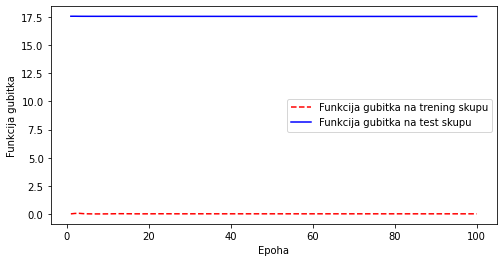

(0.014023113995790482, 17.551349639892578)

In [66]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[19], test_loss[19]

In [42]:
batch_size = 64
epochs = 10

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/10
219/219 - 4s - loss: 0.0187 - val_loss: 17.5890 - 4s/epoch - 17ms/step
Epoch 2/10
219/219 - 4s - loss: 0.0174 - val_loss: 17.5879 - 4s/epoch - 17ms/step
Epoch 3/10
219/219 - 4s - loss: 0.0176 - val_loss: 17.5873 - 4s/epoch - 17ms/step
Epoch 4/10
219/219 - 3s - loss: 0.0189 - val_loss: 17.5868 - 3s/epoch - 16ms/step
Epoch 5/10
219/219 - 3s - loss: 0.0214 - val_loss: 17.5873 - 3s/epoch - 15ms/step
Epoch 6/10
219/219 - 3s - loss: 0.0237 - val_loss: 17.5879 - 3s/epoch - 15ms/step
Epoch 7/10
219/219 - 3s - loss: 0.0248 - val_loss: 17.5868 - 3s/epoch - 15ms/step
Epoch 8/10
219/219 - 3s - loss: 0.0242 - val_loss: 17.5870 - 3s/epoch - 15ms/step
Epoch 9/10
219/219 - 3s - loss: 0.0230 - val_loss: 17.5860 - 3s/epoch - 15ms/step
Epoch 10/10
219/219 - 3s - loss: 0.0216 - val_loss: 17.5850 - 3s/epoch - 15ms/step


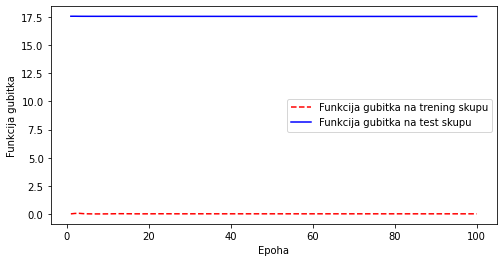

(0.010085029527544975, 17.553762435913086)

In [64]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[9], test_loss[9]

In [44]:
batch_size = 64
epochs = 30

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/30
219/219 - 4s - loss: 0.0205 - val_loss: 17.5856 - 4s/epoch - 18ms/step
Epoch 2/30
219/219 - 4s - loss: 0.0200 - val_loss: 17.5840 - 4s/epoch - 17ms/step
Epoch 3/30
219/219 - 4s - loss: 0.0203 - val_loss: 17.5844 - 4s/epoch - 16ms/step
Epoch 4/30
219/219 - 3s - loss: 0.0208 - val_loss: 17.5847 - 3s/epoch - 15ms/step
Epoch 5/30
219/219 - 3s - loss: 0.0214 - val_loss: 17.5833 - 3s/epoch - 15ms/step
Epoch 6/30
219/219 - 3s - loss: 0.0218 - val_loss: 17.5835 - 3s/epoch - 15ms/step
Epoch 7/30
219/219 - 3s - loss: 0.0221 - val_loss: 17.5829 - 3s/epoch - 15ms/step
Epoch 8/30
219/219 - 3s - loss: 0.0217 - val_loss: 17.5833 - 3s/epoch - 15ms/step
Epoch 9/30
219/219 - 3s - loss: 0.0214 - val_loss: 17.5821 - 3s/epoch - 15ms/step
Epoch 10/30
219/219 - 3s - loss: 0.0210 - val_loss: 17.5827 - 3s/epoch - 15ms/step
Epoch 11/30
219/219 - 3s - loss: 0.0208 - val_loss: 17.5816 - 3s/epoch - 15ms/step
Epoch 12/30
219/219 - 3s - loss: 0.0205 - val_loss: 17.5803 - 3s/epoch - 15ms/step
Epoch 13/30
2

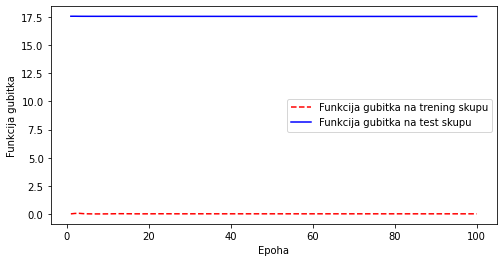

(0.015318227000534534, 17.550472259521484)

In [62]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[29], test_loss[29]

In [46]:
batch_size = 128
epochs = 30

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/30
110/110 - 2s - loss: 0.0191 - val_loss: 17.5729 - 2s/epoch - 18ms/step
Epoch 2/30
110/110 - 2s - loss: 0.0021 - val_loss: 17.5719 - 2s/epoch - 16ms/step
Epoch 3/30
110/110 - 2s - loss: 0.0018 - val_loss: 17.5721 - 2s/epoch - 17ms/step
Epoch 4/30
110/110 - 2s - loss: 0.0017 - val_loss: 17.5721 - 2s/epoch - 17ms/step
Epoch 5/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5719 - 2s/epoch - 18ms/step
Epoch 6/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5718 - 2s/epoch - 17ms/step
Epoch 7/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5718 - 2s/epoch - 16ms/step
Epoch 8/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5718 - 2s/epoch - 19ms/step
Epoch 9/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5717 - 2s/epoch - 17ms/step
Epoch 10/30
110/110 - 2s - loss: 0.0016 - val_loss: 17.5717 - 2s/epoch - 17ms/step
Epoch 11/30
110/110 - 2s - loss: 0.0017 - val_loss: 17.5717 - 2s/epoch - 18ms/step
Epoch 12/30
110/110 - 2s - loss: 0.0017 - val_loss: 17.5717 - 2s/epoch - 19ms/step
Epoch 13/30
1

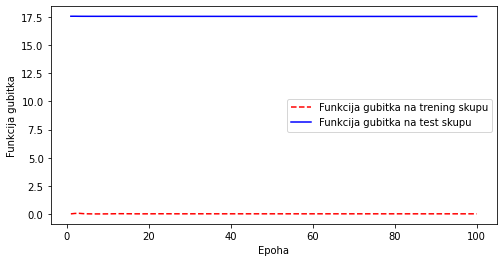

(0.015318227000534534, 17.550472259521484)

In [63]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[29], test_loss[29]

In [49]:
batch_size = 128
epochs = 100

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/100
110/110 - 2s - loss: 0.0048 - val_loss: 17.5690 - 2s/epoch - 20ms/step
Epoch 2/100
110/110 - 2s - loss: 0.0050 - val_loss: 17.5696 - 2s/epoch - 19ms/step
Epoch 3/100
110/110 - 2s - loss: 0.0057 - val_loss: 17.5690 - 2s/epoch - 16ms/step
Epoch 4/100
110/110 - 2s - loss: 0.0068 - val_loss: 17.5699 - 2s/epoch - 16ms/step
Epoch 5/100
110/110 - 2s - loss: 0.0084 - val_loss: 17.5692 - 2s/epoch - 17ms/step
Epoch 6/100
110/110 - 2s - loss: 0.0104 - val_loss: 17.5702 - 2s/epoch - 15ms/step
Epoch 7/100
110/110 - 2s - loss: 0.0126 - val_loss: 17.5691 - 2s/epoch - 16ms/step
Epoch 8/100
110/110 - 2s - loss: 0.0144 - val_loss: 17.5697 - 2s/epoch - 16ms/step
Epoch 9/100
110/110 - 2s - loss: 0.0154 - val_loss: 17.5687 - 2s/epoch - 17ms/step
Epoch 10/100
110/110 - 2s - loss: 0.0153 - val_loss: 17.5702 - 2s/epoch - 17ms/step
Epoch 11/100
110/110 - 2s - loss: 0.0142 - val_loss: 17.5682 - 2s/epoch - 19ms/step
Epoch 12/100
110/110 - 2s - loss: 0.0127 - val_loss: 17.5686 - 2s/epoch - 17ms/step
E

Epoch 99/100
110/110 - 2s - loss: 0.0096 - val_loss: 17.5562 - 2s/epoch - 16ms/step
Epoch 100/100
110/110 - 2s - loss: 0.0096 - val_loss: 17.5547 - 2s/epoch - 16ms/step


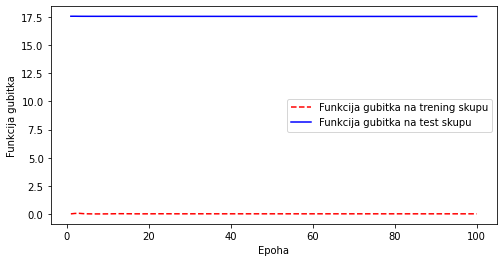

(0.013911857269704342, 17.542133331298828)

In [61]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[99], test_loss[99]

In [51]:
batch_size = 64
epochs = 100

history = model.fit(x = [X_train['USER'], X_train['ITEM']], y = Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data = ([X_test['USER'], X_test['ITEM']], Y_test))


Epoch 1/100
219/219 - 4s - loss: 0.0109 - val_loss: 17.5598 - 4s/epoch - 18ms/step
Epoch 2/100
219/219 - 4s - loss: 0.0487 - val_loss: 17.5605 - 4s/epoch - 17ms/step
Epoch 3/100
219/219 - 3s - loss: 0.0593 - val_loss: 17.5569 - 3s/epoch - 16ms/step
Epoch 4/100
219/219 - 3s - loss: 0.0310 - val_loss: 17.5547 - 3s/epoch - 16ms/step
Epoch 5/100
219/219 - 3s - loss: 0.0148 - val_loss: 17.5540 - 3s/epoch - 15ms/step
Epoch 6/100
219/219 - 3s - loss: 0.0085 - val_loss: 17.5538 - 3s/epoch - 15ms/step
Epoch 7/100
219/219 - 3s - loss: 0.0064 - val_loss: 17.5532 - 3s/epoch - 15ms/step
Epoch 8/100
219/219 - 3s - loss: 0.0060 - val_loss: 17.5535 - 3s/epoch - 15ms/step
Epoch 9/100
219/219 - 3s - loss: 0.0071 - val_loss: 17.5535 - 3s/epoch - 15ms/step
Epoch 10/100
219/219 - 3s - loss: 0.0101 - val_loss: 17.5538 - 3s/epoch - 16ms/step
Epoch 11/100
219/219 - 3s - loss: 0.0155 - val_loss: 17.5545 - 3s/epoch - 15ms/step
Epoch 12/100
219/219 - 3s - loss: 0.0223 - val_loss: 17.5551 - 3s/epoch - 15ms/step
E

Epoch 99/100
219/219 - 3s - loss: 0.0139 - val_loss: 17.5415 - 3s/epoch - 16ms/step
Epoch 100/100
219/219 - 3s - loss: 0.0139 - val_loss: 17.5421 - 3s/epoch - 15ms/step


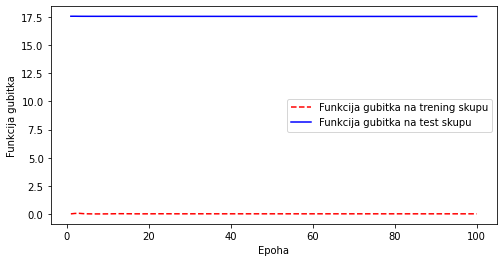

(0.013911857269704342, 17.542133331298828)

In [60]:
# Funkcija gubitka tokom treniranja i testiranja
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Broj epoha
epoch_count = range(1, len(training_loss) + 1)

# Vizualizacija gubitka kroz epohe
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Funkcija gubitka na trening skupu', 'Funkcija gubitka na test skupu'])
plt.xlabel('Epoha')
plt.ylabel('Funkcija gubitka')
plt.show()

training_loss[99], test_loss[99]

Najmanja vrednost funkcije gubitka na test skupu je 17.5 što se postiže u većini slučajeva.